In [18]:
from operator import mod
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from datasets import load_dataset
from tqdm.auto import tqdm


In [19]:
# %%
dataset_train = load_dataset(
    "uoft-cs/cifar10",
    split="train",  # training dataset
    # trust_remote_code=true,
    # ignore_verifications=true,  # set to true if seeing splits error
)
dataset_train


Dataset({
    features: ['img', 'label'],
    num_rows: 50000
})

In [20]:
# %%
dataset_val = load_dataset("uoft-cs/cifar10", split="test")
print(dataset_val)


Dataset({
    features: ['img', 'label'],
    num_rows: 10000
})


In [21]:
# %%
print(set(dataset_train["label"]))
print(dataset_train[0]["img"])
print(dataset_train[0]["img"].size)  # gotta convert all to 32, 32
print(dataset_train[0]["img"].mode)  # gotta convert all to RGB channels


{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
<PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32 at 0x7995FE95E810>
(32, 32)
RGB


In [22]:
# %%
preprocess = transforms.Compose(  # same process for training + validation data
    [
        transforms.Resize((32, 32)),
        transforms.ToTensor(),  # gives [0, 1] values
    ]
)


In [23]:
# %%
inputs_train = []
for record in tqdm(dataset_train):
    img = record["img"]
    lbl = record["label"]
    # print(lbl)
    if img.mode == "L":
        # print("one")
        img = img.convert("RGB")
    tensor = preprocess(img)
    inputs_train.append([tensor, lbl])
print(len(inputs_train))
print(inputs_train[0][0].shape)
print(inputs_train[0])


  0%|          | 0/50000 [00:00<?, ?it/s]

50000
torch.Size([3, 32, 32])
[tensor([[[0.6980, 0.6980, 0.6980,  ..., 0.6667, 0.6588, 0.6471],
         [0.7059, 0.7020, 0.7059,  ..., 0.6784, 0.6706, 0.6588],
         [0.6941, 0.6941, 0.6980,  ..., 0.6706, 0.6627, 0.6549],
         ...,
         [0.4392, 0.4431, 0.4471,  ..., 0.3922, 0.3843, 0.3961],
         [0.4392, 0.4392, 0.4431,  ..., 0.4000, 0.4000, 0.4000],
         [0.4039, 0.3922, 0.4039,  ..., 0.3608, 0.3647, 0.3569]],

        [[0.6902, 0.6902, 0.6902,  ..., 0.6588, 0.6510, 0.6392],
         [0.6980, 0.6941, 0.6980,  ..., 0.6706, 0.6627, 0.6510],
         [0.6863, 0.6863, 0.6902,  ..., 0.6627, 0.6549, 0.6471],
         ...,
         [0.4196, 0.4275, 0.4314,  ..., 0.3804, 0.3686, 0.3725],
         [0.4000, 0.4039, 0.4039,  ..., 0.3725, 0.3647, 0.3608],
         [0.3765, 0.3647, 0.3725,  ..., 0.3294, 0.3373, 0.3294]],

        [[0.7412, 0.7412, 0.7412,  ..., 0.7059, 0.6941, 0.6824],
         [0.7490, 0.7451, 0.7490,  ..., 0.7137, 0.7059, 0.6941],
         [0.7373, 0.7373, 0

In [24]:
# %%
inputs_val = []
for record in tqdm(dataset_val):
    img = record["img"]
    lbl = record["label"]
    # print(lbl)
    if img.mode == "L":
        # print("one")
        img = img.convert("RGB")
    tensor = preprocess(img)
    inputs_val.append([tensor, lbl])
print(inputs_val[0][0].shape)
print(len(inputs_val))
print(inputs_val[0])


  0%|          | 0/10000 [00:00<?, ?it/s]

torch.Size([3, 32, 32])
10000
[tensor([[[0.6196, 0.6235, 0.6471,  ..., 0.5373, 0.4941, 0.4549],
         [0.5961, 0.5922, 0.6235,  ..., 0.5333, 0.4902, 0.4667],
         [0.5922, 0.5922, 0.6196,  ..., 0.5451, 0.5098, 0.4706],
         ...,
         [0.2667, 0.1647, 0.1216,  ..., 0.1490, 0.0510, 0.1569],
         [0.2392, 0.1922, 0.1373,  ..., 0.1020, 0.1137, 0.0784],
         [0.2118, 0.2196, 0.1765,  ..., 0.0941, 0.1333, 0.0824]],

        [[0.4392, 0.4353, 0.4549,  ..., 0.3725, 0.3569, 0.3333],
         [0.4392, 0.4314, 0.4471,  ..., 0.3725, 0.3569, 0.3451],
         [0.4314, 0.4275, 0.4353,  ..., 0.3843, 0.3725, 0.3490],
         ...,
         [0.4863, 0.3922, 0.3451,  ..., 0.3804, 0.2510, 0.3333],
         [0.4549, 0.4000, 0.3333,  ..., 0.3216, 0.3216, 0.2510],
         [0.4196, 0.4118, 0.3490,  ..., 0.3020, 0.3294, 0.2627]],

        [[0.1922, 0.1843, 0.2000,  ..., 0.1412, 0.1412, 0.1294],
         [0.2000, 0.1569, 0.1765,  ..., 0.1216, 0.1255, 0.1333],
         [0.1843, 0.1294, 0

In [25]:
# %%
def get_mean_and_std(sampels_list):
    np.random.seed(0)
    # getting a random sample
    idx = np.random.randint(0, len(sampels_list), 2048)  # 2048 indexes from 5k
    # print(idx)
    tensor = torch.concat([inputs_train[i][0] for i in idx], axis=1)
    # print(tensor.shape) #for each channel, 65k pixel line x 32 columns
    tensor = tensor.swapaxes(0, 1).reshape(3, -1).T
    # print(tensor.shape)
    # print(tensor)# each column is a channel, so get its mean + std
    mean = torch.mean(tensor, axis=0)
    std = torch.std(tensor, axis=0)
    # print(mean)
    # print(std)
    del tensor
    return mean, std
mean, std = get_mean_and_std(inputs_train)
print(mean)
print(std)


tensor([0.4700, 0.4740, 0.4749])
tensor([0.2485, 0.2502, 0.2537])


In [26]:
# %%
preprocess = transforms.Compose([transforms.Normalize(mean=mean, std=std)])
# preprocess_val = transforms.Compose([transforms.Normalize(mean=mean_v, std=std_v)])


In [27]:
# %%
for i in tqdm(range(len(inputs_train))):
    tensor = preprocess(inputs_train[i][0])
    inputs_train[i][0] = tensor
inputs_train[0][0]


  0%|          | 0/50000 [00:00<?, ?it/s]

tensor([[[ 0.9176,  0.9176,  0.9176,  ...,  0.7914,  0.7598,  0.7125],
         [ 0.9492,  0.9334,  0.9492,  ...,  0.8387,  0.8072,  0.7598],
         [ 0.9019,  0.9019,  0.9176,  ...,  0.8072,  0.7756,  0.7440],
         ...,
         [-0.1240, -0.1083, -0.0925,  ..., -0.3134, -0.3450, -0.2977],
         [-0.1240, -0.1240, -0.1083,  ..., -0.2819, -0.2819, -0.2819],
         [-0.2661, -0.3134, -0.2661,  ..., -0.4397, -0.4239, -0.4555]],

        [[ 0.8640,  0.8640,  0.8640,  ...,  0.7386,  0.7073,  0.6602],
         [ 0.8954,  0.8797,  0.8954,  ...,  0.7856,  0.7543,  0.7073],
         [ 0.8483,  0.8483,  0.8640,  ...,  0.7543,  0.7229,  0.6916],
         ...,
         [-0.2175, -0.1862, -0.1705,  ..., -0.3743, -0.4213, -0.4056],
         [-0.2959, -0.2802, -0.2802,  ..., -0.4056, -0.4370, -0.4527],
         [-0.3900, -0.4370, -0.4056,  ..., -0.5780, -0.5467, -0.5780]],

        [[ 1.0498,  1.0498,  1.0498,  ...,  0.9106,  0.8643,  0.8179],
         [ 1.0807,  1.0652,  1.0807,  ...,  0

In [28]:
# %%
for i in tqdm(range(len(inputs_val))):
    tensor = preprocess(inputs_val[i][0])
    inputs_val[i][0] = tensor
inputs_val[0][0]


  0%|          | 0/10000 [00:00<?, ?it/s]

tensor([[[ 0.6020,  0.6178,  0.7125,  ...,  0.2705,  0.0969, -0.0609],
         [ 0.5073,  0.4915,  0.6178,  ...,  0.2548,  0.0811, -0.0136],
         [ 0.4915,  0.4915,  0.6020,  ...,  0.3021,  0.1601,  0.0022],
         ...,
         [-0.8185, -1.2289, -1.4025,  ..., -1.2920, -1.6866, -1.2604],
         [-0.9290, -1.1184, -1.3394,  ..., -1.4814, -1.4341, -1.5761],
         [-1.0395, -1.0079, -1.1815,  ..., -1.5130, -1.3551, -1.5603]],

        [[-0.1392, -0.1548, -0.0765,  ..., -0.4056, -0.4683, -0.5624],
         [-0.1392, -0.1705, -0.1078,  ..., -0.4056, -0.4683, -0.5154],
         [-0.1705, -0.1862, -0.1548,  ..., -0.3586, -0.4056, -0.4997],
         ...,
         [ 0.0489, -0.3273, -0.5154,  ..., -0.3743, -0.8915, -0.5624],
         [-0.0765, -0.2959, -0.5624,  ..., -0.6094, -0.6094, -0.8915],
         [-0.2175, -0.2489, -0.4997,  ..., -0.6878, -0.5780, -0.8445]],

        [[-1.1145, -1.1454, -1.0836,  ..., -1.3155, -1.3155, -1.3619],
         [-1.0836, -1.2537, -1.1764,  ..., -1

In [29]:
# %%
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    inputs_train, batch_size=batch_size, shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    inputs_val, batch_size=batch_size, shuffle=True
)


In [30]:
# %%
for batch_images, batch_labels in val_loader:
    print(f"Batch shape: {batch_images.shape}, Labels: {batch_labels}")
    break
for batch_images, batch_labels in train_loader:
    print(f"Batch shape: {batch_images.shape}, Labels: {batch_labels}")
    break


Batch shape: torch.Size([64, 3, 32, 32]), Labels: tensor([8, 9, 8, 4, 2, 2, 4, 4, 8, 9, 9, 2, 6, 2, 2, 2, 2, 0, 1, 3, 1, 0, 6, 2,
        3, 5, 3, 6, 9, 4, 5, 3, 5, 2, 2, 6, 7, 9, 3, 9, 9, 3, 6, 7, 8, 8, 7, 2,
        1, 8, 4, 8, 0, 4, 6, 6, 2, 3, 3, 4, 3, 9, 5, 4])
Batch shape: torch.Size([64, 3, 32, 32]), Labels: tensor([4, 5, 3, 5, 4, 9, 5, 1, 9, 2, 1, 4, 1, 8, 4, 5, 6, 8, 3, 3, 7, 1, 0, 4,
        3, 1, 0, 1, 6, 0, 1, 2, 2, 0, 4, 1, 8, 7, 5, 4, 0, 8, 3, 5, 4, 1, 8, 4,
        6, 5, 2, 5, 9, 0, 2, 7, 6, 5, 7, 5, 8, 3, 6, 3])


In [31]:
# %%
# Data is ready, now contruct CNN architecture
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [32]:
# %%
class ConvNeuralNet(nn.Module):
    def __init__(self, num_classes):
        super(ConvNeuralNet, self).__init__()
        # 1st; basic paterns, lines/edges...
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, padding=1)
        self.relu1 = nn.ReLU()
        self.max_pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        # 2nd: basic shapes, corners...
        self.conv2 = nn.Conv2d(
            in_channels=64, out_channels=192, kernel_size=4, padding=1
        )
        self.relu2 = nn.ReLU()
        self.max_pool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        # 3rd; more complex shapes, squares, circles...
        # + beginnig of deep stacking conv layers before pooling
        self.conv3 = nn.Conv2d(
            in_channels=192, out_channels=384, kernel_size=3, padding=1
        )
        self.relu3 = nn.ReLU()
        # 4th: recognizing component of objects, like wheels...
        # + NN plateus after reaching max channels
        self.conv4 = nn.Conv2d(
            in_channels=384, out_channels=256, kernel_size=3, padding=1
        )
        self.relu4 = nn.ReLU()
        # 5th; recognizing full objects based on what components theyre made of
        self.conv5 = nn.Conv2d(
            in_channels=256, out_channels=256, kernel_size=3, padding=1
        )
        self.relu5 = nn.ReLU()
        self.max_pool5 = nn.MaxPool2d(kernel_size=3, stride=2)
        # now smooth gradual reduction 1024-512-256-10
        # with Dropout to avoid overfitting
        self.dropout6 = nn.Dropout(p=0.5)
        self.fc6 = nn.Linear(1024, 512)
        self.relu6 = nn.ReLU()
        self.dropout7 = nn.Dropout(p=0.5)
        self.fc7 = nn.Linear(512, 256)
        self.relu7 = nn.ReLU()
        self.fc8 = nn.Linear(256, num_classes)

    # now the forward method
    def forward(self, x):
        # 1st conv bloc
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.max_pool1(out)
        # 2nd conv bloc
        out = self.conv2(out)
        out = self.relu2(out)
        out = self.max_pool2(out)
        # 3rd conv bloc (deep stack)
        out = self.conv3(out)
        out = self.relu3(out)
        # 4th conv bloc
        out = self.conv4(out)
        out = self.relu4(out)
        # 5th conv bloc
        out = self.conv5(out)
        out = self.relu5(out)
        out = self.max_pool5(out)
        # reshaping
        out = out.reshape(out.size(0), -1)
        # fc layer: 1024 -> 512
        out = self.dropout6(out)
        out = self.fc6(out)
        out = self.relu6(out)
        # fc layer: 512 -> 256
        out = self.dropout7(out)
        out = self.fc7(out)
        out = self.relu7(out)
        # final fc layer
        out = self.fc8(out)
        return out



In [33]:
# %%
model = ConvNeuralNet(num_classes=10).to(device)
# Loss function
loss_func = nn.CrossEntropyLoss()
# Optimizer: Stochastic gradient, with .008 as LR
optimizer = torch.optim.SGD(model.parameters(), lr=0.008)


In [34]:
# %%
epochs = 50
for epoch in range(epochs):
    model.train()
    for i, (imgs, lables) in enumerate(train_loader):
        imgs = imgs.to(device)
        lables = lables.to(device)
        # forward propg
        outputs = model(imgs)
        loss = loss_func(outputs, lables)
        # back propg
        optimizer.zero_grad()
        loss.backward()  # get gradients
        optimizer.step()  # update weights
    # testing on validation set after each epoch
    with torch.no_grad():
        model.eval()
        corrct = 0
        total = 0
        loss_history = []
        for imgs, labels in val_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            outputs = model(imgs)
            predected = torch.argmax(outputs, dim=1)
            total += labels.size(0)
            #
            corrct += (predected == labels).sum().item()
            loss_history.append(loss_func(outputs, labels).item())
        #
        mean_acc = 100 * (corrct / total)
        #
        mean_loss = sum(loss_history) / len(loss_history)
    print(
        "Epoch [{}/{}], Loss: {:.4f}, Val-loss: {:.4f}, Val-acc: {:.1f}%".format(
            epoch + 1, epochs, loss.item(), mean_loss, mean_acc
        )
    )
torch.save(model, "classic_cnn.pt")



Epoch [1/50], Loss: 2.3029, Val-loss: 2.3010, Val-acc: 10.0%
Epoch [2/50], Loss: 2.2944, Val-loss: 2.2833, Val-acc: 15.4%
Epoch [3/50], Loss: 2.1526, Val-loss: 1.9769, Val-acc: 22.7%
Epoch [4/50], Loss: 2.0852, Val-loss: 1.8828, Val-acc: 24.5%
Epoch [5/50], Loss: 1.7026, Val-loss: 1.8570, Val-acc: 25.0%
Epoch [6/50], Loss: 1.7021, Val-loss: 1.9755, Val-acc: 27.1%
Epoch [7/50], Loss: 2.0124, Val-loss: 1.9463, Val-acc: 28.0%
Epoch [8/50], Loss: 1.6346, Val-loss: 1.6316, Val-acc: 35.8%
Epoch [9/50], Loss: 1.6083, Val-loss: 1.7212, Val-acc: 35.3%
Epoch [10/50], Loss: 1.4705, Val-loss: 1.5057, Val-acc: 43.2%
Epoch [11/50], Loss: 1.5041, Val-loss: 1.3071, Val-acc: 50.6%
Epoch [12/50], Loss: 1.3368, Val-loss: 1.3130, Val-acc: 51.3%
Epoch [13/50], Loss: 1.5563, Val-loss: 1.4767, Val-acc: 46.2%
Epoch [14/50], Loss: 1.7228, Val-loss: 1.9783, Val-acc: 36.2%
Epoch [15/50], Loss: 1.4024, Val-loss: 1.1766, Val-acc: 57.1%
Epoch [16/50], Loss: 1.6117, Val-loss: 1.1084, Val-acc: 60.5%
Epoch [17/50], Lo

In [35]:
#model = torch.load("classic_cnn.pt", weights_only = False)
model.eval()

ConvNeuralNet(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (max_pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 192, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (max_pool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (conv4): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (conv5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu5): ReLU()
  (max_pool5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout6): Dropout(p=0.5, inplace=False)
  (fc6): Linear(in_features=1024, out_features=512, bias=True)
  (relu6): ReLU()
  (dropout7): Dropout(p=0.5, inplace=False)
  (fc7): Linear(in_features=512, out_features=256, bias=True)
  (

In [36]:
# %%
data_test = load_dataset(
    "uoft-cs/cifar10",
    split="test",  # test set
)
preprocess = transforms.Compose(
    [
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ]
)


In [37]:
# %%
#testing with the first 10 pics
print(dataset_val)
testing_set = []
for img in dataset_val["img"][:10]:
    tensor = preprocess(img)
    testing_set.append(tensor.to(device))
print(len(testing_set))
print(testing_set[0].shape)


Dataset({
    features: ['img', 'label'],
    num_rows: 10000
})
10
torch.Size([3, 32, 32])


In [38]:
# %%
#stack them up to a single tensor
test_tensor = torch.stack(testing_set)
test_tensor.shape


torch.Size([10, 3, 32, 32])

In [39]:
# %%
#process the testing tensors
outputs = model(test_tensor)
predicted = torch.argmax(outputs, dim = 1)
print(predicted)
print(predicted.shape)


tensor([3, 8, 1, 0, 6, 6, 9, 6, 3, 1], device='cuda:0')
torch.Size([10])


In [40]:
# %%
print("Ground truth values: ")
for i in range(10):
    print(dataset_val['label'][i])


Ground truth values: 
3
8
8
0
6
6
1
6
3
1


Image n°  0


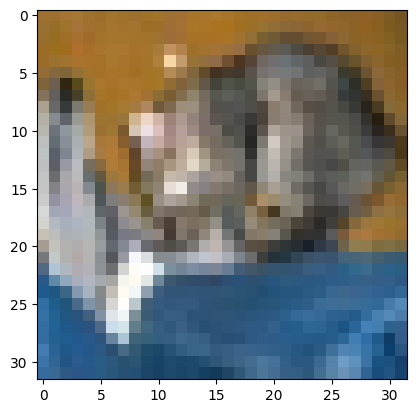

Ground Tuth:  cat
Predicted:  cat
Image n°  1


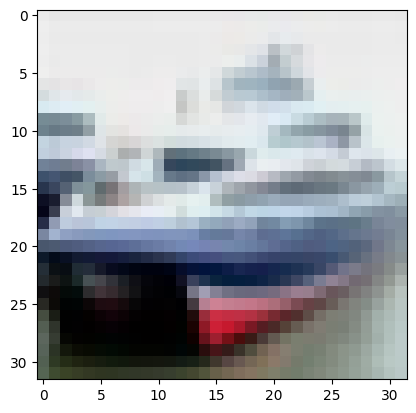

Ground Tuth:  ship
Predicted:  ship
Image n°  2


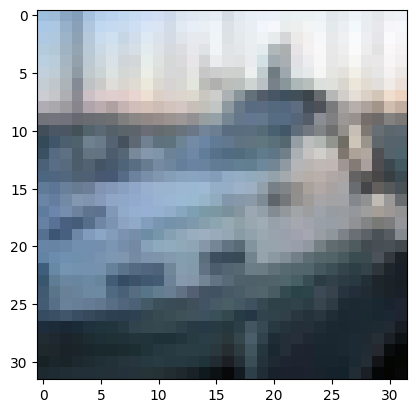

Ground Tuth:  ship
Predicted:  automobile
Image n°  3


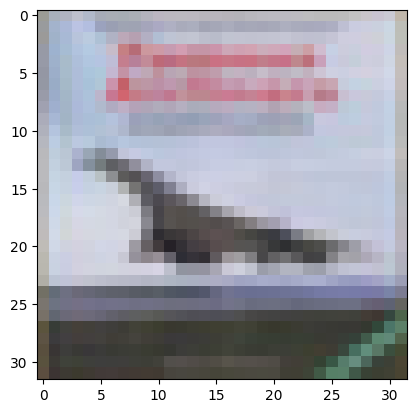

Ground Tuth:  airplane
Predicted:  airplane
Image n°  4


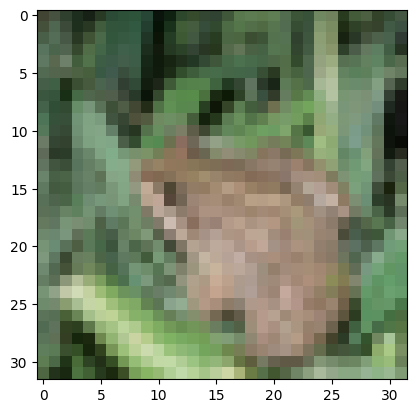

Ground Tuth:  frog
Predicted:  frog
Image n°  5


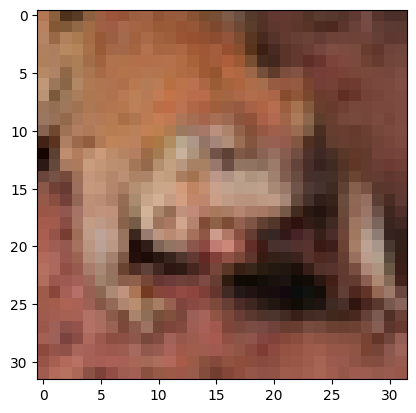

Ground Tuth:  frog
Predicted:  frog
Image n°  6


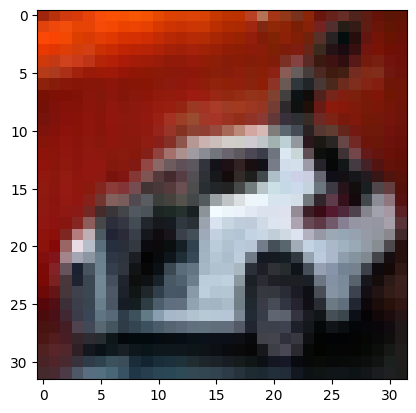

Ground Tuth:  automobile
Predicted:  truck
Image n°  7


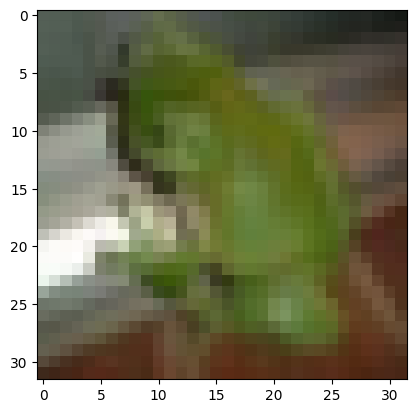

Ground Tuth:  frog
Predicted:  frog
Image n°  8


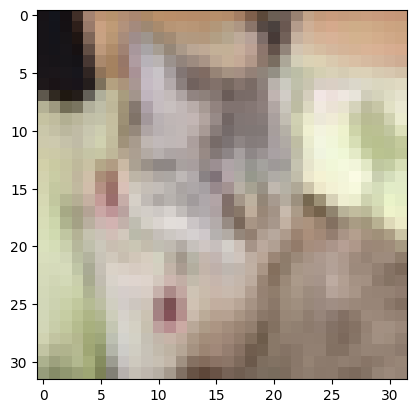

Ground Tuth:  cat
Predicted:  cat
Image n°  9


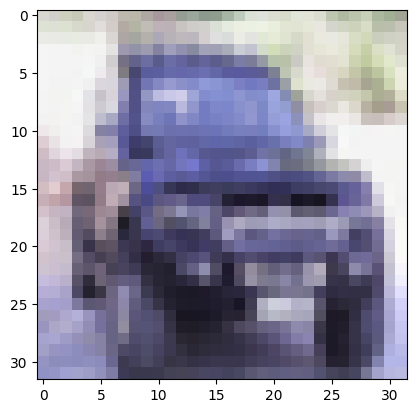

Ground Tuth:  automobile
Predicted:  automobile


In [41]:
# %%
import matplotlib.pyplot as plt
for i, img in enumerate(dataset_val['img'][:10]):
    print("Image n° ", i)
    plt.imshow(img)
    plt.show()
    print("Ground Tuth: ", dataset_val.features["label"].names[dataset_val["label"][i]])
    print("Predicted: ", dataset_val.features["label"].names[predicted[i]])

